In [ ]:
# dla ms > 1 dla msl mean mse się polepsza ze wzrostem a std spada , ms < 1 jest odwrotnie 


In [2]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
import os
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from sklearn.base import clone
import ast
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle

## Data import

In [77]:
# import requests

# # List of raw URLs of the CSV files
# csv_urls = [
#     'https://raw.githubusercontent.com/Bartekb3/pi_br_greater_than_1/main/processed_data/preprocessed_cj/preprocessed_bike_sharing.csv',
#     'https://raw.githubusercontent.com/Bartekb3/pi_br_greater_than_1/main/processed_data/preprocessed_cj/preprocessed_boston.csv',
#     'https://raw.githubusercontent.com/Bartekb3/pi_br_greater_than_1/main/processed_data/preprocessed_cj/preprocessed_concrete_compressive_strength.csv',
#     'https://raw.githubusercontent.com/Bartekb3/pi_br_greater_than_1/main/processed_data/preprocessed_cj/preprocessed_infrared_thermography_temperature.csv',
#     'https://raw.githubusercontent.com/Bartekb3/pi_br_greater_than_1/main/processed_data/preprocessed_cj/preprocessed_paris_housing.csv'
# ]

# # Directory to save the downloaded files
# save_dir = './'

# for url in csv_urls:
#     response = requests.get(url)
#     if response.status_code == 200:
#         # Extract the filename from the URL
#         filename = url.split('/')[-1]
#         # Full path to save the file
#         file_path = save_dir + filename
#         # Write the content to a file
#         with open(file_path, 'wb') as file:
#             file.write(response.content)
#         print(f'Successfully downloaded {filename}')
#     else:
#         print(f'Failed to download {url}')


In [65]:
# # https://github.com/Bartekb3/pi_br_greater_than_1/tree/main/results/wyniki_misiu
# import requests

# # List of raw URLs of the CSV files
# csv_urls = [
#     'https://github.com/Bartekb3/pi_br_greater_than_1/tree/main/results/wyniki_misiu/wyniki_Daily_Demand_Forecasting_Orders_misiu.csv',
#     'https://github.com/Bartekb3/pi_br_greater_than_1/tree/main/results/wyniki_misiu/wyniki_Facebook_misiu.csv',
#     'https://github.com/Bartekb3/pi_br_greater_than_1/tree/main/results/wyniki_misiu/wyniki_bupa_misiu.csv',
#     'https://github.com/Bartekb3/pi_br_greater_than_1/tree/main/results/wyniki_misiu/wyniki_combined_misiu.csv',
#     'https://github.com/Bartekb3/pi_br_greater_than_1/tree/main/results/wyniki_misiu/wyniki_forestfires_misiu.csv',
#     'https://github.com/Bartekb3/pi_br_greater_than_1/tree/main/results/wyniki_misiu/wyniki_screen_time_misiu.csv',
#     'https://github.com/Bartekb3/pi_br_greater_than_1/tree/main/results/wyniki_misiu/wyniki_servo_misiu.csv',

# ]

# # Directory to save the downloaded files
# save_dir = './'

# for url in csv_urls:
#     response = requests.get(url)
#     if response.status_code == 200:
#         # Extract the filename from the URL
#         filename = url.split('/')[-1]
#         # Full path to save the file
#         file_path = save_dir + filename
#         # Write the content to a file
#         with open(file_path, 'wb') as file:
#             file.write(response.content)
#         print(f'Successfully downloaded {filename}')
#     else:
#         print(f'Failed to download {url}')

Successfully downloaded wyniki_Daily_Demand_Forecasting_Orders_misiu.csv
Successfully downloaded wyniki_Facebook_misiu.csv
Successfully downloaded wyniki_bupa_misiu.csv
Successfully downloaded wyniki_combined_misiu.csv
Successfully downloaded wyniki_forestfires_misiu.csv
Successfully downloaded wyniki_screen_time_misiu.csv
Successfully downloaded wyniki_servo_misiu.csv


# Main

## Functions

In [6]:
#modele takie same jak w oryginale, wyrzuciłem jedynie kryterium podziału bo w regresji to jest po prostu mse

########################################### MODELS ##########################################
cpu_no = 12
rf_100 =    ('RF[100]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, n_estimators=100))
rf_200 =    ('RF[200]', RandomForestRegressor(random_state=123, n_jobs=cpu_no,  n_estimators=200))
rf_500 =    ('RF[500]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, n_estimators=500))
#rf_entr =   ('  RF[entr]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, criterion="entropy"))
rf_md_10 =  ('RF[md10]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, max_depth=10))
rf_md_15 =  ('RF[md15]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, max_depth=15))
rf_md_20 =  ('RF[md20]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, max_depth=20))
rf_md_25 =  ('RF[md25]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, max_depth=25))
rf_mss_3 =  ('RF[mss3]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, min_samples_split=3))
rf_mss_4 =  ('RF[mss4]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, min_samples_split=4))
rf_mss_6 =  ('RF[mss6]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, min_samples_split=6))
rf_mss_8 =  ('RF[mss8]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, min_samples_split=8))
rf_msl_2 =  ('RF[msl2]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, min_samples_leaf=2))
rf_msl_3 =  ('RF[msl3]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, min_samples_leaf=3))
rf_msl_4 =  ('RF[msl4]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, min_samples_leaf=4))
rf_msl_5 =  ('RF[msl5]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, min_samples_leaf=5))
rf_mf_log = ('RF[mfLog2]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, max_features="log2"))
rf_mf_all = ('RF[mfAll]', RandomForestRegressor(random_state=123, n_jobs=cpu_no, max_features=None))
######################################## END OF MODELS ######################################

######################################### PARAMETERS ########################################
max_samples = [0.2, 0.6, 0.8, 1, 1.2, 2, 3, 4, 5]
# max_samples = [0.2]
forests = [rf_100, rf_200, rf_500, rf_md_10, rf_md_15, rf_md_20, rf_md_25, rf_mss_3, rf_mss_4, rf_mss_6, rf_mss_8,
        rf_msl_2, rf_msl_3, rf_msl_4, rf_msl_5, rf_mf_log, rf_mf_all]

##################################### END OF PARAMETERS #####################################

#duplikujemy dane zeby dalo sie zrobic br>1
def make_X_train(X_tra, y_tra, max_sample):
    if max_sample <= 1:
        return X_tra, y_tra
    elif 1 < max_sample < 2:
        return np.tile(X_tra, (2, 1)), np.tile(y_tra, 2)
    else:
        return np.tile(X_tra, (max_sample, 1)), np.tile(y_tra, max_sample)

In [7]:
#to zrobcie tak jak tutaj albo wpiszcie ręcznie do dataset_paths sciezki do datasetow

path_to_datasets = './preprocessed_data' #'path/to/folder/with/datasets'

dataset_paths = []
for filename in os.listdir(path_to_datasets):
    full_path = os.path.join(path_to_datasets, filename)
    dataset_paths.append(full_path)

In [8]:
def process_fold(train_index, test_index, X, y, ms, rfr):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_tr, y_tr = make_X_train(X_train, y_train, ms)

    rfr_fold = clone(rfr[1])
    rfr_fold.max_samples = None if ms >= 1 and ms != 1.2 else (0.6 if ms == 1.2 else ms)
    rfr_fold.fit(X_tr, y_tr)

    y_hat = rfr_fold.predict(X_test)
    return mean_squared_error(y_test, y_hat)

## Moje (niewazne)

In [ ]:
# data = pd.read_csv('./preprocessed_data/preprocessed_bike_sharing.csv')
# data_train,data_test = train_test_split(data, test_size=0.2, random_state=42)
# rfr = RandomForestRegressor(random_state=123, n_jobs=20, n_estimators=100, max_samples=0.2)
# X = data_train.iloc[:, :-1]
# y = data_train.iloc[:, -1]
# rfr.fit(X, y)
# y_predict = rfr.predict(data_test.iloc[:, :-1].to_numpy())
# print(mean_squared_error(data_test.iloc[:, -1].to_numpy(), y_predict))
# print(f'Data size in KB: {data_train.memory_usage(deep=True).sum() / 1024}')
# print(f'Test data size in KB: {data_test.memory_usage(deep=True).sum() / 1024}')

# # top 8 features
# feature_importance_dataframe = pd.DataFrame()
# feature_importance_dataframe['Feature'] = rfr.feature_names_in_
# feature_importance_dataframe['Importance'] = rfr.feature_importances_
# feature_importance_dataframe = feature_importance_dataframe.sort_values(by='Importance', ascending=False)
# top_8_features = feature_importance_dataframe.head(5)
# X = X[top_8_features['Feature']]
# y = data_train.iloc[:, -1]
# rfr8 = RandomForestRegressor(random_state=123, n_jobs=20, n_estimators=100, max_samples=0.2)
# rfr8.fit(X, y)
# y_predict8 = rfr8.predict(data_test.iloc[:, :-1][top_8_features['Feature']].to_numpy())
# print(mean_squared_error(data_test.iloc[:, -1].to_numpy(), y_predict8))
# print(f'Data size in KB: {data_train[top_8_features["Feature"]].memory_usage(deep=True).sum() / 1024}')
# print(f'Test data size in KB: {data_test[top_8_features["Feature"]].memory_usage(deep=True).sum() / 1024}')

# # PCA
# data = pd.read_csv('./preprocessed_data/preprocessed_bike_sharing.csv')
# data_train,data_test = train_test_split(data, test_size=0.2, random_state=42)
# X = data_train.iloc[:, :-1]
# y = data_train.iloc[:, -1]
# pca = PCA()
# X_pca = pd.DataFrame(pca.fit_transform(X))
# X_pca_test = pd.DataFrame(pca.transform(data_test.iloc[:, :-1]))
# rfr2 = RandomForestRegressor(random_state=123, n_jobs=20, n_estimators=100, max_samples=0.2)
# rfr2.fit(X_pca, y)
# y_predict2 = rfr2.predict(X_pca_test)
# print(mean_squared_error(data_test.iloc[:, -1].to_numpy(), y_predict2))
# print(f'Data size in KB: {X_pca.memory_usage(deep=True).sum() / 1024}')
# print(f'Test data size in KB: {X_pca_test.memory_usage(deep=True).sum() / 1024}')

# # Smaller data 
# data_train,useless = train_test_split(data_train, test_size=0.8, random_state=42)
# rfr3 = RandomForestRegressor(random_state=123, n_jobs=20, n_estimators=100, max_samples=0.2)
# rfr3.fit(data_train.iloc[:, :-1], data_train.iloc[:, -1])
# y_predict3 = rfr3.predict(data_test.iloc[:, :-1])
# print(mean_squared_error(data_test.iloc[:, -1], y_predict3))
# print(f'Data size in KB: {data_train.memory_usage(deep=True).sum() / 1024}')
# print(f'Test data size in KB: {data_test.memory_usage(deep=True).sum() / 1024}')

# # 8 features + smaller data
# top_8_features = feature_importance_dataframe.head(8)
# X = data_train.iloc[:, :-1][top_8_features['Feature']]
# y = data_train.iloc[:, -1]
# rfr4 = RandomForestRegressor(random_state=123, n_jobs=20, n_estimators=100, max_samples=0.2)
# rfr4.fit(X, y)
# y_predict4 = rfr4.predict(data_test.iloc[:, :-1][top_8_features['Feature']])
# print(mean_squared_error(data_test.iloc[:, -1], y_predict4))
# print(f'Data size in KB: {X.memory_usage(deep=True).sum() / 1024}')
# print(f'Test data size in KB: {data_test[top_8_features["Feature"]].memory_usage(deep=True).sum() / 1024}')

# # data_to_save_train = data_train[top_8_features['Feature']]
# # data_to_save_train['cnt'] = data_train['cnt']
# # data_to_save_test = data_test[top_8_features['Feature']]
# # data_to_save_test['cnt'] = data_test['cnt']
# # data_to_save = pd.concat([data_to_save_train, data_to_save_test])
# # data_to_save.to_csv('bike_sharing_8_features.csv', index=False)


c:\Users\jancw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


2245.229846346375
Data size in KB: 2063.7265625
Test data size in KB: 515.96875


c:\Users\jancw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


4246.704179336318
Data size in KB: 651.703125
Test data size in KB: 162.9375
8394.815681501726
Data size in KB: 1846.62109375
Test data size in KB: 461.78515625
4770.050153279631
Data size in KB: 412.65625
Test data size in KB: 515.96875
4062.9508564425905
Data size in KB: 195.46875
Test data size in KB: 244.40625


In [273]:
# feature_importance_dataframe = pd.DataFrame()
# feature_importance_dataframe['Feature'] = rfr.feature_names_in_
# feature_importance_dataframe['Importance'] = rfr.feature_importances_
# feature_importance_dataframe = feature_importance_dataframe.sort_values(by='Importance', ascending=False)
# plt.figure(figsize=(10, 6))
# plt.barh(feature_importance_dataframe['Feature'], feature_importance_dataframe['Importance'], )
# plt.xlabel('Importance')
# plt.title('Feature Importance')
# plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


data = pd.read_csv('./preprocessed_data/preprocessed_paris_housing.csv')
data.drop(columns=['squareMeters'], inplace=True, axis=1)
data['price'] = (data['price'] - data['price'].min()) / (data['price'].max() - data['price'].min())
data_train,data_test = train_test_split(data, test_size=0.2, random_state=42)
rfr = RandomForestRegressor(random_state=123, n_jobs=20, n_estimators=100, max_samples=0.2)
X = data_train.iloc[:, :-1]
y = data_train.iloc[:, -1]
rfr.fit(X, y)
y_predict = rfr.predict(data_test.iloc[:, :-1].to_numpy())
print(mean_squared_error(data_test.iloc[:, -1].to_numpy(), y_predict))
print(f'Data size in KB: {data_train.memory_usage(deep=True).sum() / 1024}')
print(f'Test data size in KB: {data_test.memory_usage(deep=True).sum() / 1024}')

# top 8 features
feature_importance_dataframe = pd.DataFrame()
feature_importance_dataframe['Feature'] = rfr.feature_names_in_
feature_importance_dataframe['Importance'] = rfr.feature_importances_
feature_importance_dataframe = feature_importance_dataframe.sort_values(by='Importance', ascending=False)
top_8_features = feature_importance_dataframe.head(3)
X = X[top_8_features['Feature']]
y = data_train.iloc[:, -1]
rfr8 = RandomForestRegressor(random_state=123, n_jobs=20, n_estimators=100, max_samples=0.2)
rfr8.fit(X, y)
y_predict8 = rfr8.predict(data_test.iloc[:, :-1][top_8_features['Feature']].to_numpy())
print(mean_squared_error(data_test.iloc[:, -1].to_numpy(), y_predict8))
print(f'Data size in KB: {data_train[top_8_features["Feature"]].memory_usage(deep=True).sum() / 1024}')
print(f'Test data size in KB: {data_test[top_8_features["Feature"]].memory_usage(deep=True).sum() / 1024}')

# PCA
data = pd.read_csv('./preprocessed_data/preprocessed_paris_housing.csv')
data.drop(columns=['squareMeters'], inplace=True, axis=1)
data['price'] = (data['price'] - data['price'].min()) / (data['price'].max() - data['price'].min())
data_train,data_test = train_test_split(data, test_size=0.2, random_state=42)
X = data_train.iloc[:, :-1]
y = data_train.iloc[:, -1]
pca = PCA()
X_pca = pd.DataFrame(pca.fit_transform(X))
X_pca_test = pd.DataFrame(pca.transform(data_test.iloc[:, :-1]))
rfr2 = RandomForestRegressor(random_state=123, n_jobs=20, n_estimators=100, max_samples=0.2)
rfr2.fit(X_pca, y)
y_predict2 = rfr2.predict(X_pca_test)
print(mean_squared_error(data_test.iloc[:, -1].to_numpy(), y_predict2))
print(f'Data size in KB: {X_pca.memory_usage(deep=True).sum() / 1024}')
print(f'Test data size in KB: {X_pca_test.memory_usage(deep=True).sum() / 1024}')

# Smaller data 
data_train,useless = train_test_split(data_train, test_size=0.8, random_state=42)
rfr3 = RandomForestRegressor(random_state=123, n_jobs=20, n_estimators=100, max_samples=0.2)
rfr3.fit(data_train.iloc[:, :-1], data_train.iloc[:, -1])
y_predict3 = rfr3.predict(data_test.iloc[:, :-1])
print(mean_squared_error(data_test.iloc[:, -1].to_numpy(), y_predict3))
print(f'Data size in KB: {data_train.memory_usage(deep=True).sum() / 1024}')
print(f'Test data size in KB: {data_test.memory_usage(deep=True).sum() / 1024}')

# 8 features + smaller data
top_8_features = feature_importance_dataframe.head(8)
X = data_train.iloc[:, :-1][top_8_features['Feature']]
y = data_train.iloc[:, -1]
rfr4 = RandomForestRegressor(random_state=123, n_jobs=20, n_estimators=100, max_samples=0.2)
rfr4.fit(X, y)
y_predict4 = rfr4.predict(data_test.iloc[:, :-1][top_8_features['Feature']])
print(mean_squared_error(data_test.iloc[:, -1].to_numpy(), y_predict4))
print(f'Data size in KB: {X.memory_usage(deep=True).sum() / 1024}')
print(f'Test data size in KB: {data_test[top_8_features["Feature"]].memory_usage(deep=True).sum() / 1024}')

# data_to_save_train = data_train[top_8_features['Feature']]
# data_to_save_train['price'] = data_train['price']
# data_to_save_test = data_test[top_8_features['Feature']]
# data_to_save_test['price'] = data_test['price']
# data_to_save = pd.concat([data_to_save_train, data_to_save_test])
# data_to_save.to_csv('bike_sharing_8_features.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: './preprocessed_data/preprocessed_paris_housing.csv'

In [274]:
# data = pd.read_csv('./preprocessed_data/bike_sharing_8_features.csv')
# # data.drop(columns=['squareMeters'], inplace=True, axis=1)
# # data['price'] = (data['price'] - data['price'].min()) / (data['price'].max() - data['price'].min())
# data_train,data_test = train_test_split(data, test_size=0.2, random_state=42)
# rfr = RandomForestRegressor(random_state=123, n_jobs=20, n_estimators=300, max_samples=0.3)
# X = data_train.iloc[:, :-1]
# y = data_train.iloc[:, -1]
# rfr.fit(X, y)
# y_predict = rfr.predict(data_test.iloc[:, :-1].to_numpy())
# print(mean_squared_error(data_test.iloc[:, -1].to_numpy(), y_predict))

# Odpalanie datasetow

In [ ]:
# TODO:
# './preprocessed_data\\bike_sharing_8_features.csv', - :DD
#  './preprocessed_data\\paris_housing_8_features.csv',- :((
#  './preprocessed_data\\preprocessed_boston.csv',  - :DD
#  './preprocessed_data\\preprocessed_concrete_compressive_strength.csv',  - :DD
#  './preprocessed_data\\preprocessed_infrared_thermography_temperature.csv' - :((

In [275]:
try:
    with open('saved_results.pkl', 'rb') as f:
        results = pickle.load(f)
except:
    results = {'dataset' : [],
           'bootstrap_rate': [],
           'rf' : [],
           'cv_mse_scores' : [],
           'mean_mse' : [],
           'std_mse' : []}
    
scaler = StandardScaler()
cvsplit = RepeatedKFold(n_splits=2, n_repeats=10, random_state=42)

dataset_path = './preprocessed_data/preprocessed_boston.csv'
df =  pd.read_csv(dataset_path)

X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

# X = scaler.fit_transform(X)

max_samples = [0.2, 0.6, 0.8, 1, 1.2, 2, 3, 4, 5]

forests = [rf_100, rf_200, rf_500, rf_md_10, rf_md_15, rf_md_20, rf_md_25, rf_mss_3, rf_mss_4, rf_mss_6, rf_mss_8,
        rf_msl_2, rf_msl_3, rf_msl_4, rf_msl_5, rf_mf_log, rf_mf_all]

for ms in max_samples:
    for rfr in forests:
        print(f'Processing {dataset_path} with bootstrap rate {ms} and model {rfr[0]}  ...')

        cv_mse_scores = Parallel(n_jobs=-1)(
            delayed(process_fold)(train_index, test_index, X, y, ms, rfr)
            for train_index, test_index in cvsplit.split(X, y)
        )

        results['dataset'].append(dataset_path)
        results['bootstrap_rate'].append(ms)
        results['rf'].append(rfr[0])
        results['cv_mse_scores'].append(cv_mse_scores)
        results['mean_mse'].append(f'{np.mean(cv_mse_scores):.3f}')
        results['std_mse'].append(f'{np.std(cv_mse_scores):.3f}')

with open('saved_results.pkl', 'wb') as f:
    pickle.dump(results, f)

Processing ./preprocessed_data/preprocessed_boston.csv with bootstrap rate 0.2 and model RF[100]  ...


KeyboardInterrupt: 

In [38]:
with open('saved_results_boston.pkl', 'rb') as f:
        results = pickle.load(f)
results_dataframe = pd.DataFrame()
for id in range(len(results['dataset'])):
    results_dataframe = pd.concat([results_dataframe, pd.DataFrame({'dataset': [results['dataset'][id]],
                                                                    'bootstrap_rate': [results['bootstrap_rate'][id]],
                                                                    'rf': [results['rf'][id]],
                                                                    'mean_mse': [results['mean_mse'][id]],
                                                                    'std_mse': [results['std_mse'][id]]})], ignore_index=True)
results_dataframe['mean_mse'] = results_dataframe['mean_mse'].astype(float)
results_dataframe['std_mse'] = results_dataframe['std_mse'].astype(float)
results_dataframe.head()

,dataset,bootstrap_rate,rf,mean_mse,std_mse
0,./preprocessed_data/preprocessed_boston.csv,0.2,RF[100],17.565,3.695
1,./preprocessed_data/preprocessed_boston.csv,0.2,RF[200],17.439,3.673
2,./preprocessed_data/preprocessed_boston.csv,0.2,RF[500],17.347,3.635
3,./preprocessed_data/preprocessed_boston.csv,0.2,RF[md10],17.573,3.687
4,./preprocessed_data/preprocessed_boston.csv,0.2,RF[md15],17.565,3.696


# Wykresy i analiza

## Wczytanie danych

In [94]:
results_dataframe = pd.read_csv('./wyniki/wyniki_screen_time_misiu.csv')
# results_dataframe = pd.read_csv('./wyniki/wyniki_bupa_misiu.csv')
# results_dataframe = pd.read_csv('./wyniki/wyniki_Daily_Demand_Forecasting_Orders_misiu.csv')
# results_dataframe = pd.read_csv('./wyniki/wyniki_Facebook_misiu.csv')
# results_dataframe = pd.read_csv('./wyniki/wyniki_forestfires_misiu.csv')
# results_dataframe = pd.read_csv('./wyniki/wyniki_servo_misiu.csv')
results_dataframe['mean_mse'] = results_dataframe['mean_mse'].astype(float)
results_dataframe['std_mse'] = results_dataframe['std_mse'].astype(float)
results_dataframe.drop(columns=['cv_mse_scores'], inplace=True, axis=1)

In [53]:
with open('saved_results.pkl', 'rb') as f:
        results = pickle.load(f)
results_dataframe = pd.DataFrame()
for id in range(len(results['dataset'])):
    results_dataframe = pd.concat([results_dataframe, pd.DataFrame({'dataset': [results['dataset'][id]],
                                                                    'bootstrap_rate': [results['bootstrap_rate'][id]],
                                                                    'rf': [results['rf'][id]],
                                                                    'mean_mse': [results['mean_mse'][id]],
                                                                    'std_mse': [results['std_mse'][id]]})], ignore_index=True)
results_dataframe['mean_mse'] = results_dataframe['mean_mse'].astype(float)
results_dataframe['std_mse'] = results_dataframe['std_mse'].astype(float)
results_dataframe.head()

,dataset,bootstrap_rate,rf,mean_mse,std_mse
0,./preprocessed_data/preprocessed_boston.csv,0.2,RF[100],17.394,3.532
1,./preprocessed_data/preprocessed_boston.csv,0.2,RF[200],17.119,3.418
2,./preprocessed_data/preprocessed_boston.csv,0.2,RF[500],17.035,3.428
3,./preprocessed_data/preprocessed_boston.csv,0.2,RF[md10],17.394,3.532
4,./preprocessed_data/preprocessed_boston.csv,0.2,RF[md15],17.392,3.527


## Funkcje do wykresow

In [130]:
import plotly.express as px
import pandas as pd

def scatter_plot_ms(df):
    # Create the interactive scatter plot with dropdown
    fig = px.scatter(
        df,
        x="mean_mse",
        y="std_mse",
        color="rf",
        color_discrete_sequence=[
            'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive',
            'cyan', 'magenta', 'yellow', 'black', 'teal', 'navy', 'coral', 'lightgreen',
            'lavender', 'tan'
        ],
        animation_frame="bootstrap_rate",
        title="Random Forest Models: Mean MSE vs Std MSE",
        labels={
            "mean_mse": "Mean MSE",
            "std_mse": "Standard Deviation of MSE",
            "rf": "Random Forest Model"
        },
        hover_data=["dataset"]
    )

    # Update layout
    fig.update_layout(
        height=600,
        width=800,
        legend_title_text='RF Model',
        hovermode='closest',
        updatemenus=[{
            "buttons": [{
                "args": [None, {"frame": {"duration": 500, "redraw": True},
                                "fromcurrent": True, "transition": {"duration": 300}}],
                "label": "Play",
                "method": "animate"
            }],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }]
    )

    # Show the plot
    fig.show()

def scatter_plot_rf(df):
    # Create figure with all data
    fig = px.scatter(
        df,
        x="mean_mse",
        y="std_mse",
        color="bootstrap_rate",
        color_continuous_scale=px.colors.sequential.Viridis,
        title=f"Random Forest Models: {df['rf'].iloc[0]}",  # Show first model initially
        labels={
            "mean_mse": "Mean MSE",
            "std_mse": "Standard Deviation of MSE",
            "bootstrap_rate": "Bootstrap Rate",
            "rf": "Random Forest Model"
        },
        hover_data={
            "dataset": True,  # Show dataset path
            "rf": True,      # Show RF model name
            "mean_mse": ":.2f",  # Format with 2 decimal places
            "std_mse": ":.2f",   # Format with 2 decimal places
            "bootstrap_rate": ":.2f"  # Format with 2 decimal places
        },
        custom_data='rf'
    )
    
    # Update hover template to include all relevant information
    fig.update_traces(
        hovertemplate=(
            "<b>RF Model</b>: %{customdata[0]}<br>"
            "<b>Mean MSE</b>: %{x:.2f}<br>"
            "<b>Std MSE</b>: %{y:.2f}<br>"
            "<b>Bootstrap Rate</b>: %{marker.color:.2f}<br>"
            "<b>Dataset</b>: %{text}<br>"
            "<extra></extra>"
        ),
        text=df['dataset']  # Add dataset as text for hover
    )

    # Create buttons for dropdown
    buttons = []
    for rf_model in df['rf'].unique():
        filtered_df = df[df['rf'] == rf_model]
        buttons.append(
            dict(
                args=[{
                    'x': [filtered_df['mean_mse']],
                    'y': [filtered_df['std_mse']],
                    'marker.color': [filtered_df['bootstrap_rate']],
                    'text': [filtered_df['dataset']],
                    'customdata': [[m] for m in filtered_df['rf']]
                },
                {
                    'title.text': f"Random Forest Models: {rf_model}"
                }],
                label=rf_model,
                method='restyle'
            )
        )
    
    # Add "All" button
    buttons.insert(0, dict(args=[{
        'x': [df['mean_mse']],
        'y': [df['std_mse']],
        'marker.color': [df['bootstrap_rate']],
        'text': [df['dataset']],
        'customdata': [[m] for m in df['rf']]
    },
    {
        'title.text': "Random Forest Models: All"
    }],
    label="All",
    method='restyle'))

    fig.update_layout(
        height=600,
        width=800,
        coloraxis_colorbar=dict(title="Bootstrap Rate"),
        updatemenus=[{
            "buttons": buttons,
            "direction": "down",
            "showactive": True,
            "x": 0.1,
            "xanchor": "left",
            "y": 1.1,
            "yanchor": "top",
        }]
    )

    fig.show()

def scatter_plot_rf_2(df):
    # Get unique RF models
    rf_models = ['All',
        'RF[100]', 'RF[200]', 'RF[500]',
        'RF[md10]', 'RF[md15]', 'RF[md20]', 'RF[md25]',
        'RF[mss3]', 'RF[mss4]', 'RF[mss6]', 'RF[mss8]',
        'RF[msl2]', 'RF[msl3]', 'RF[msl4]', 'RF[msl5]',
        'RF[mfLog2]', 'RF[mfAll]'
    ]

    # Define color map for bootstrap rates
    bootstrap_rates = df['bootstrap_rate'].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(bootstrap_rates)))
    color_map = dict(zip(bootstrap_rates, colors))

    @interact(rf_model=rf_models)
    def plot_rf_model(rf_model):
        if rf_model == 'All':
            subset = df.copy()
        else:
            subset = df[df['rf'] == rf_model]
        # add all button
        # subset_all = df.copy()
        # subset = pd.concat([subset, subset_all], ignore_index=True)
        
        fig = px.scatter(
            subset,
            x="mean_mse",
            y="std_mse",
            color="bootstrap_rate",
            color_continuous_scale='Viridis',
            title=f"MSE Analysis for {rf_model} (Color by Bootstrap Rate)",
            labels={
                "mean_mse": "Mean MSE",
                "std_mse": "Standard Deviation of MSE",
                "bootstrap_rate": "Bootstrap Rate"
            },
            hover_data=["dataset"]
        )
        
        fig.update_layout(
            height=600,
            width=800,
            coloraxis_colorbar=dict(title="Bootstrap Rate"),
            hovermode='closest'
        )
        
        fig.show()

def stacked_histogram(df):
    fig = px.histogram(
        df,
        x="mean_mse",
        color="bootstrap_rate",
        color_discrete_sequence=px.colors.sequential.Viridis,
        title="Distribution of Mean MSE by Bootstrap Rate",
        labels={
            "mean_mse": "Mean MSE",
            "count": "Frequency",
            "bootstrap_rate": "Bootstrap Rate"
        },
        nbins=30,  # Adjust number of bins as needed
        opacity=0.8,
        barmode='stack'  # This creates the stacked bars
    )
    
    # Update layout for better visualization
    fig.update_layout(
        height=600,
        width=800,
        bargap=0.1,  # Gap between bars of different x values
        coloraxis_colorbar=dict(title="Bootstrap Rate"),
        hovermode='x unified',  # Shows hover info for all stacks at current x
        xaxis_title="Mean MSE",
        yaxis_title="Frequency"
    )
    
    # Customize hover information
    fig.update_traces(
        hovertemplate=(
            "<b>Mean MSE range</b>: %{x}<br>"
            "<b>Count</b>: %{y}<br>"
            "<extra></extra>"
        )
    )
    
    fig.show()

def line_plot_mean_mse(df):
    fig = px.line(
        df,
        x="bootstrap_rate",
        y="mean_mse",
        color="rf",
        title="Mean MSE vs Bootstrap Rate for Random Forest Models",
        labels={
            "bootstrap_rate": "Bootstrap Rate",
            "mean_mse": "Mean MSE",
            "rf": "Random Forest Model"
        },
        markers=True
    )
    
    fig.update_layout(
        height=600,
        width=800,
        legend_title_text='RF Model',
        hovermode='closest'
    )
    
    fig.show()


## Analiza wyników

In [40]:
ms_temp_mse_dict = {}
for ms in max_samples:
    ms_temp_mse_dict[ms] = []

for i in range(len(results['cv_mse_scores'])):
    print(f"Dataset: {results['dataset'][i]}, Bootstrap Rate: {results['bootstrap_rate'][i]}, "
          f"Model: {results['rf'][i]}, "
          f"Mean MSE: {results['mean_mse'][i]}, Std MSE: {results['std_mse'][i]}")
    ms_temp_mse_dict[results['bootstrap_rate'][i]].append(float(results['mean_mse'][i]))
    
# top n mean mse and bootstrap rate
sorted_results = sorted(zip(results['mean_mse'], results['bootstrap_rate'], results['rf']), key=lambda x: x[0])
top_n = 20
top_n_results = sorted_results[:top_n]
print(f"Top {top_n} results:")
print(top_n_results)

Dataset: ./preprocessed_data/paris_housing_8_features.csv, Bootstrap Rate: 0.2, Model: RF[100], Mean MSE: 0.087, Std MSE: 0.001
Dataset: ./preprocessed_data/paris_housing_8_features.csv, Bootstrap Rate: 0.2, Model: RF[200], Mean MSE: 0.087, Std MSE: 0.001
Dataset: ./preprocessed_data/paris_housing_8_features.csv, Bootstrap Rate: 0.2, Model: RF[500], Mean MSE: 0.086, Std MSE: 0.001
Dataset: ./preprocessed_data/paris_housing_8_features.csv, Bootstrap Rate: 0.2, Model: RF[md10], Mean MSE: 0.087, Std MSE: 0.001
Dataset: ./preprocessed_data/paris_housing_8_features.csv, Bootstrap Rate: 0.2, Model: RF[md15], Mean MSE: 0.087, Std MSE: 0.001
Dataset: ./preprocessed_data/paris_housing_8_features.csv, Bootstrap Rate: 0.2, Model: RF[md20], Mean MSE: 0.087, Std MSE: 0.001
Dataset: ./preprocessed_data/paris_housing_8_features.csv, Bootstrap Rate: 0.2, Model: RF[md25], Mean MSE: 0.087, Std MSE: 0.001
Dataset: ./preprocessed_data/paris_housing_8_features.csv, Bootstrap Rate: 0.2, Model: RF[mss3], Mea

In [271]:
dataset_paths = [
    'saved_results_boston.pkl',
    'saved_results_bs.pkl',
    'saved_results_concrete.pkl']

for dataset_path in dataset_paths:
    with open(dataset_path, 'rb') as f:
        results = pickle.load(f)
    results_dataframe = pd.DataFrame()
    for id in range(len(results['dataset'])):
        results_dataframe = pd.concat([results_dataframe, pd.DataFrame({'dataset': [results['dataset'][id]],
                                                                        'bootstrap_rate': [results['bootstrap_rate'][id]],
                                                                        'rf': [results['rf'][id]],
                                                                        'mean_mse': [results['mean_mse'][id]],
                                                                        'std_mse': [results['std_mse'][id]]})], ignore_index=True)
    results_dataframe['mean_mse'] = results_dataframe['mean_mse'].astype(float)
    results_dataframe['std_mse'] = results_dataframe['std_mse'].astype(float)
    print(f"Dataset: {dataset_path}")
    scatter_plot_rf(results_dataframe)
    scatter_plot_ms(results_dataframe)
    stacked_histogram(results_dataframe)
    line_plot_mean_mse(results_dataframe)

Dataset: saved_results_boston.pkl


Dataset: saved_results_bs.pkl


Dataset: saved_results_concrete.pkl


In [272]:
dataset_paths = [
    './wyniki/wyniki_screen_time_misiu.csv',
    './wyniki/wyniki_bupa_misiu.csv',
    './wyniki/wyniki_Daily_Demand_Forecasting_Orders_misiu.csv',
    './wyniki/wyniki_Facebook_misiu.csv',
    './wyniki/wyniki_forestfires_misiu.csv',
    './wyniki/wyniki_servo_misiu.csv']
for dataset_path in dataset_paths:
    results_dataframe = pd.read_csv(dataset_path)
    results_dataframe['mean_mse'] = results_dataframe['mean_mse'].astype(float)
    results_dataframe['std_mse'] = results_dataframe['std_mse'].astype(float)
    print(f"Dataset: {dataset_path}")
    scatter_plot_rf(results_dataframe)
    scatter_plot_ms(results_dataframe)
    stacked_histogram(results_dataframe)
    line_plot_mean_mse(results_dataframe)

Dataset: ./wyniki/wyniki_screen_time_misiu.csv


Dataset: ./wyniki/wyniki_bupa_misiu.csv


Dataset: ./wyniki/wyniki_Daily_Demand_Forecasting_Orders_misiu.csv


Dataset: ./wyniki/wyniki_Facebook_misiu.csv


Dataset: ./wyniki/wyniki_forestfires_misiu.csv


Dataset: ./wyniki/wyniki_servo_misiu.csv


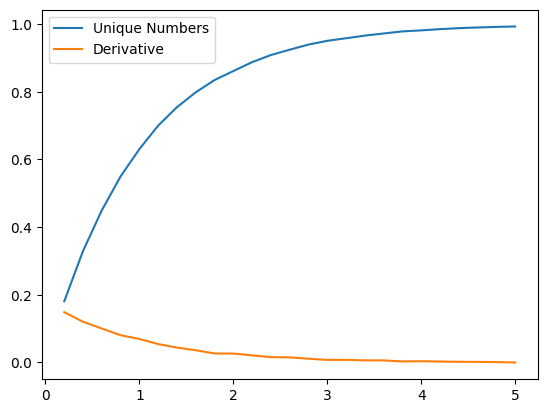

In [268]:
import random
import numpy as np
def draw_from_set(n,set_size):
    lista = []
    for i in range(n):
        lista.append(random.randint(1, set_size))
    unique_numbers = set(lista)
    return len(unique_numbers)/set_size

result_list = []
for i in np.arange(0.2, 5.1, 0.2):
    result_list.append(draw_from_set(int(i*100000),100000))

# display results_list and derivative on same plot
derivative = np.diff(result_list,append=result_list[-1])
plt.plot(np.arange(0.2, 5.1, 0.2), result_list, label='Unique Numbers')
plt.plot(np.arange(0.2, 5.1, 0.2), derivative, label='Derivative')
plt.legend()
plt.show()  